## Package

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import os.path
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import glorot_uniform
#import visualkeras
from tensorflow.keras.optimizers import Adam

from IPython.display import Markdown, display
import seaborn as sns

# from lib import proc_img
# from lib import create_gen

def printmd(string):
    #Print with Markdowns    
    display(Markdown(string))

In [2]:
%load_ext autotime
RANDOM_STATE = 42

In [3]:
seed = 7
np.random.seed(seed)

In [4]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder+'/'+random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off');
    #print(f"Image shape {img.shape}")
    return img

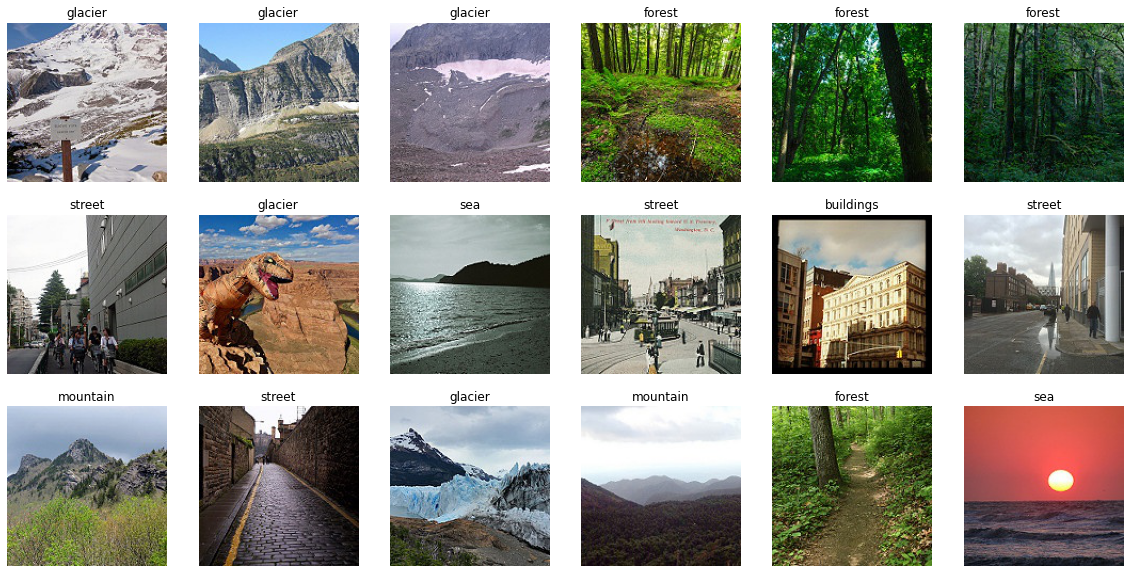

In [5]:
import random
import matplotlib.image as mpimg
from pathlib import Path
import os.path
class_names=['buildings', 'forest', 'glacier', 'mountain' ,'sea' ,'street']
plt.figure(figsize=(20, 10))
for i in range(18):
    plt.subplot(3, 6, i+1)
    class_name = random.choice(class_names)
    img = view_random_image(target_dir='/home/abir/Downloads/greedyhpo/intel/archive/seg_train/seg_train/',target_class=class_name)

In [6]:
train_dir = "/home/abir/Downloads/greedyhpo/intel/archive/seg_train/seg_train"
test_dir = "/home/abir/Downloads/greedyhpo/intel/archive/seg_test/seg_test"
val_dir ="/home/abir/Downloads/greedyhpo/intel/archive/seg_val/seg_test/"

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_data = ImageDataGenerator(rescale = 1./255)

training_data = train_data.flow_from_directory(train_dir,
                                              batch_size = 32,
                                              target_size = (32,32), 
                                              class_mode = 'categorical')

val_data = ImageDataGenerator(rescale = 1./255)

validation_data = val_data.flow_from_directory(val_dir,
                                            batch_size = 32,
                                            target_size = (32,32), 
                                            class_mode = 'categorical')


test_data = ImageDataGenerator(rescale = 1./255)

testing_data = test_data.flow_from_directory(test_dir,
                                            batch_size = 32,
                                            target_size = (32,32), 
                                            class_mode = 'categorical')

Found 14034 images belonging to 6 classes.
Found 2400 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


In [8]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [9]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [10]:
dense_sizes_1 = [64,128,256,512]
dense_sizes_2 = [64,128,256,512]
learning_rates_1 = [1e-3,1e-1, 1e-2, 1e-4, 1e-5]

s1_filter_sizes_1 = [16,32,64,128,256,512]

s2_filter_sizes_1 = [16,32,64,128,256,512]
s2_filter_sizes_2 = [16,32,64,128,256,512]
s2_filter_sizes_3 = [128,256,512,1024,2048]

s3_filter_sizes_1 = [16,32,64,128,256,512]
s3_filter_sizes_2 = [16,32,64,128,256,512]
s3_filter_sizes_3 = [128,256,512,1024,2048]

s4_filter_sizes_1 = [16,32,64,128,256,512]
s4_filter_sizes_2 = [16,32,64,128,256,512]
s4_filter_sizes_3 = [128,256,512,1024,2048]

s5_filter_sizes_1 = [16,32,64,128,256,512]
s5_filter_sizes_2 = [16,32,64,128,256,512]
s5_filter_sizes_3 = [128,256,512,1024,2048]

dp_sizes_1 = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
dp_sizes_2 = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]

wd_sizes_1=[0.0,0.1, 0.001, 0.0001]
wd_sizes_2=[0.0,0.1, 0.001, 0.0001]

opt_layer_1=0.001
opt_layer_2=64
opt_layer_3=64
opt_layer_4=16
opt_layer_5=16
opt_layer_6=16
opt_layer_7=128
opt_layer_8=16
opt_layer_9=16
opt_layer_10=128
opt_layer_11=16
opt_layer_12=16
opt_layer_13=128
opt_layer_14=16
opt_layer_15=16
opt_layer_16=128
opt_layer_17=0.0
opt_layer_18=0.0
opt_layer_19=0.0
opt_layer_20=0.0

temp=0
test_acc=0
combinations=0
flag=0
for wd_size_2 in wd_sizes_2 :
    for wd_size_1 in wd_sizes_1 :
        for dp_size_2 in dp_sizes_2 :
            for dp_size_1 in dp_sizes_1 :
                for s5_filter_size_3 in s5_filter_sizes_3:
                    for s5_filter_size_2 in s5_filter_sizes_2:
                        for s5_filter_size_1 in s5_filter_sizes_1:
                            for s4_filter_size_3 in s4_filter_sizes_3:
                                for s4_filter_size_2 in s4_filter_sizes_2:
                                    for s4_filter_size_1 in s4_filter_sizes_1 :
                                        for s3_filter_size_3 in s3_filter_sizes_3:
                                            for s3_filter_size_2 in s3_filter_sizes_2:
                                                for s3_filter_size_1 in s3_filter_sizes_1:
                                                    for s2_filter_size_3 in s2_filter_sizes_3:
                                                        for s2_filter_size_2 in s2_filter_sizes_2:
                                                            for s2_filter_size_1 in s2_filter_sizes_1:
                                                                for s1_filter_size_1 in s1_filter_sizes_1:
                                                                    for dense_size_2 in dense_sizes_2:
                                                                        for dense_size_1 in dense_sizes_1:
                                                                            for learning_rate_1 in learning_rates_1:
                                                                                print(learning_rate_1,dense_size_1,dense_size_2,s1_filter_size_1,s2_filter_size_1,s2_filter_size_2,s2_filter_size_3,s3_filter_size_1,s3_filter_size_2,s3_filter_size_3,s4_filter_size_1,s4_filter_size_2,s4_filter_size_3,s5_filter_size_1,s5_filter_size_2,s5_filter_size_3,dp_size_1,dp_size_2,wd_size_1,wd_size_2)
                                                                                input_shape=(32, 32, 3)
                                                                                X_input = Input(input_shape)

                                                                                X = ZeroPadding2D((1, 1))(X_input)

                                                                                X = Conv2D(s1_filter_size_1, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
                                                                                X = BatchNormalization(axis=3, name='bn_conv1')(X)
                                                                                X = Activation('relu')(X)
                                                                                X = MaxPooling2D((3, 3), strides=(2, 2))(X)

                                                                                X = convolutional_block(X, f=3, filters=[s2_filter_size_1, s2_filter_size_2, s2_filter_size_3], stage=2, block='a', s=1)
                                                                                X = identity_block(X, 3, [s2_filter_size_1, s2_filter_size_2, s2_filter_size_3], stage=2, block='b')
                                                                                X = identity_block(X, 3, [s2_filter_size_1, s2_filter_size_2, s2_filter_size_3], stage=2, block='c')

                                                                                X = convolutional_block(X, f=3, filters=[s3_filter_size_1, s3_filter_size_2, s3_filter_size_3], stage=3, block='a', s=2)
                                                                                X = identity_block(X, 3, [s3_filter_size_1, s3_filter_size_2, s3_filter_size_3], stage=3, block='b')
                                                                                X = identity_block(X, 3, [s3_filter_size_1, s3_filter_size_2, s3_filter_size_3], stage=3, block='c')
                                                                                X = identity_block(X, 3, [s3_filter_size_1, s3_filter_size_2, s3_filter_size_3], stage=3, block='d')

                                                                                X = convolutional_block(X, f=3, filters=[s4_filter_size_1, s4_filter_size_2, s4_filter_size_3], stage=4, block='a', s=2)
                                                                                X = identity_block(X, 3, [s4_filter_size_1, s4_filter_size_2, s4_filter_size_3], stage=4, block='b')
                                                                                X = identity_block(X, 3, [s4_filter_size_1, s4_filter_size_2, s4_filter_size_3], stage=4, block='c')
                                                                                X = identity_block(X, 3, [s4_filter_size_1, s4_filter_size_2, s4_filter_size_3], stage=4, block='d')
                                                                                X = identity_block(X, 3, [s4_filter_size_1, s4_filter_size_2, s4_filter_size_3], stage=4, block='e')
                                                                                X = identity_block(X, 3, [s4_filter_size_1, s4_filter_size_2, s4_filter_size_3], stage=4, block='f')

                                                                                X = convolutional_block(X, f=3, filters=[s5_filter_size_1, s5_filter_size_2, s5_filter_size_3], stage=5, block='a', s=2)
                                                                                X = identity_block(X, 3, [s5_filter_size_1, s5_filter_size_2, s5_filter_size_3], stage=5, block='b')
                                                                                X = identity_block(X, 3, [s5_filter_size_1, s5_filter_size_2, s5_filter_size_3], stage=5, block='c')

                                                                                X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

                                                                                X= Dropout(dp_size_1)(X)
                                                                                X = Flatten()(X)
                                                                                X=Dense(dense_size_1, activation='relu',kernel_regularizer=regularizers.l2(wd_size_1), name='fc1',kernel_initializer=glorot_uniform(seed=0))(X)
                                                                                X=Dense(dense_size_2, activation='relu',kernel_regularizer=regularizers.l2(wd_size_2), name='fc2',kernel_initializer=glorot_uniform(seed=0))(X)
                                                                                X= Dropout(dp_size_2)(X)
                                                                                X = Dense(6,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(X)

                                                                                model = Model(inputs=X_input, outputs=X, name='ResNet50')

                                                                                my_callbacks = [ tf.keras.callbacks.EarlyStopping(patience=3)]
                                                                                opt = Adam(learning_rate=learning_rate_1)

                                                                                model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                                                                                                                optimizer=opt,
                                                                                                                metrics=['accuracy'])
                                                                                model.fit(training_data,
                                                                                          batch_size=64,
                                                                                          epochs=100,
                                                                                          validation_data=validation_data,
                                                                                          callbacks=[my_callbacks])
                                                                                

                                                                                _,test_acc = model.evaluate(validation_data)
                                                                                print("Current Acc: ",test_acc)
                                                                                print("Best Acc: ",temp)
                                                                                combinations=combinations+1
                                                                                if flag==0 :
                                                                                    if test_acc > temp :
                                                                                        opt_layer_1 = learning_rate_1
                                                                                        temp=test_acc
                                                                                    learning_rates_1 = [opt_layer_1]

                                                                                elif flag==1 :
                                                                                    if test_acc > temp :
                                                                                        opt_layer_2 = dense_size_1
                                                                                        temp=test_acc
                                                                                    dense_sizes_1 = [opt_layer_2]

                                                                                elif flag==2 :
                                                                                    if test_acc > temp :
                                                                                        opt_layer_3 = dense_size_2
                                                                                        temp=test_acc
                                                                                    dense_sizes_2 = [opt_layer_3]

                                                                                elif flag==3 :
                                                                                    if test_acc > temp :
                                                                                        opt_layer_4 = s1_filter_size_1
                                                                                        temp=test_acc
                                                                                    s1_filter_sizes_1 = [opt_layer_4]
                                                                                    
                                                                                elif flag==4 :
                                                                                    if test_acc > temp :
                                                                                        opt_layer_5 = s2_filter_size_1
                                                                                        temp=test_acc
                                                                                    s2_filter_sizes_1 = [opt_layer_5]
                                                                                    
                                                                                elif flag==5 :
                                                                                    if test_acc > temp :
                                                                                        opt_layer_6 = s2_filter_size_2
                                                                                        temp=test_acc
                                                                                    s2_filter_sizes_2 = [opt_layer_6]
                                                                                    
                                                                                elif flag==6 :
                                                                                    if test_acc > temp :
                                                                                        opt_layer_7 = s2_filter_size_3
                                                                                        temp=test_acc
                                                                                    s2_filter_sizes_3 = [opt_layer_7]

                                                                                elif flag==7 :
                                                                                    if test_acc > temp :
                                                                                        opt_layer_8 = s3_filter_size_1
                                                                                        temp=test_acc
                                                                                    s3_filter_sizes_1 = [opt_layer_8]
                                                                                    
                                                                                elif flag==8 :
                                                                                    if test_acc > temp :
                                                                                        opt_layer_9 = s3_filter_size_2
                                                                                        temp=test_acc
                                                                                    s3_filter_sizes_2 = [opt_layer_9]
                                                                                    
                                                                                elif flag==9 :
                                                                                    if test_acc > temp :
                                                                                        opt_layer_10 = s3_filter_size_3
                                                                                        temp=test_acc
                                                                                    s3_filter_sizes_3 = [opt_layer_10]
                                                                                    
                                                                                elif flag==10 :
                                                                                    if test_acc > temp :
                                                                                        opt_layer_11 = s4_filter_size_1
                                                                                        temp=test_acc
                                                                                    s4_filter_sizes_1 = [opt_layer_11]
                                                                                    
                                                                                elif flag==11 :
                                                                                    if test_acc > temp :
                                                                                        opt_layer_12 = s4_filter_size_2
                                                                                        temp=test_acc
                                                                                    s4_filter_sizes_2 = [opt_layer_9]
                                                                                    
                                                                                elif flag==12 :
                                                                                    if test_acc > temp :
                                                                                        opt_layer_13 = s4_filter_size_3
                                                                                        temp=test_acc
                                                                                    s4_filter_sizes_3 = [opt_layer_13]
                                                                                    
                                                                                elif flag==13 :
                                                                                    if test_acc > temp :
                                                                                        opt_layer_14 = s5_filter_size_1
                                                                                        temp=test_acc
                                                                                    s5_filter_sizes_1 = [opt_layer_14]
                                                                                    
                                                                                elif flag==14 :
                                                                                    if test_acc > temp :
                                                                                        opt_layer_15 = s5_filter_size_2
                                                                                        temp=test_acc
                                                                                    s5_filter_sizes_2 = [opt_layer_15]
                                                                                    
                                                                                elif flag==15 :
                                                                                    if test_acc > temp :
                                                                                        opt_layer_16 = s5_filter_size_3
                                                                                        temp=test_acc
                                                                                    s5_filter_sizes_3 = [opt_layer_16]
                                                                                    
                                                                                elif flag==16 :
                                                                                    if test_acc > temp :
                                                                                        opt_layer_17 = dp_size_1
                                                                                        temp=test_acc
                                                                                    dp_sizes_1 = [opt_layer_17]
                                                                                    
                                                                                elif flag==17 :
                                                                                    if test_acc > temp :
                                                                                        opt_layer_18 = dp_size_2
                                                                                        temp=test_acc
                                                                                    dp_sizes_2 = [opt_layer_18]
                                                                                    
                                                                                elif flag==18 :
                                                                                    if test_acc > temp :
                                                                                        opt_layer_19 = wd_size_1
                                                                                        temp=test_acc
                                                                                    wd_sizes_1 = [opt_layer_19]
                                                                                    
                                                                                elif flag==19 :
                                                                                    if test_acc > temp :
                                                                                        opt_layer_20 = wd_size_2
                                                                                        temp=test_acc
                                                                                    wd_sizes_2 = [opt_layer_20]
                                                                            flag=1
                                                                            test_acc=0
                                                                        flag=2
                                                                        test_acc=0
                                                                    flag=3
                                                                    test_acc=0
                                                                flag=4
                                                                test_acc=0
                                                            flag=5
                                                            test_acc=0
                                                        flag=6
                                                        test_acc=0
                                                    flag=7
                                                    test_acc=0
                                                flag=8
                                                test_acc=0
                                            flag=9
                                            test_acc=0
                                        flag=10
                                        test_acc=0  
                                    flag=11
                                    test_acc=0
                                flag=12
                                test_acc=0
                            flag=13
                            test_acc=0
                        flag=14
                        test_acc=0
                    flag=15
                    test_acc=0
                flag=16
                test_acc=0
            flag=17
            test_acc=0
        flag=18
        test_acc=0
    flag=19
    test_acc=0
    
print("######################################################################################################")
print("Trials: ",combinations)
print("Optimal Validation Accuracy",temp)
print("The Final Optimal Values for all block is : ")
print("learning rate: ",opt_layer_1,"\ndense_size_1: ",opt_layer_2,"\ndense_size_2: ",opt_layer_3,"\ns1_filter_size_1: ",opt_layer_4,"\ns2_filter_size_1: ",opt_layer_5,"\ns2_filter_size_2: ",opt_layer_6,"\ns2_filter_size_3: ",opt_layer_7,"\ns3_filter_size_1: ",opt_layer_8,"\ns3_filter_size_2: ",opt_layer_9,"\ns3_filter_size_3: ",opt_layer_10,"\ns4_filter_size_1: ",opt_layer_11,"\ns4_filter_size_2: ",opt_layer_12,"\ns4_filter_size_3: ",opt_layer_13,"\ns5_filter_size_1: ",opt_layer_14,"\ns5_filter_size_2: ",opt_layer_15,"\ns5_filter_size_3: ",opt_layer_16,"\ndp_size_1: ",opt_layer_17,"\ndp_size_2: ",opt_layer_18,"\nwd_size_1: ",opt_layer_19,"\nwd_size_2: ",opt_layer_20)                      

0.001 64 64 16 16 16 128 16 16 128 16 16 128 16 16 128 0.0 0.0 0.0 0.0
Epoch 1/100
439/439 [==============================] - 16s 25ms/step - loss: 1.5038 - accuracy: 0.3744 - val_loss: 1.3744 - val_accuracy: 0.4508
Epoch 2/100
439/439 [==============================] - 10s 23ms/step - loss: 1.1734 - accuracy: 0.5298 - val_loss: 1.2955 - val_accuracy: 0.4992
Epoch 3/100
439/439 [==============================] - 10s 23ms/step - loss: 1.0753 - accuracy: 0.5717 - val_loss: 1.0646 - val_accuracy: 0.5792
Epoch 4/100
439/439 [==============================] - 10s 23ms/step - loss: 1.0144 - accuracy: 0.6104 - val_loss: 1.2678 - val_accuracy: 0.5158
Epoch 5/100
439/439 [==============================] - 10s 23ms/step - loss: 0.9546 - accuracy: 0.6362 - val_loss: 0.9684 - val_accuracy: 0.6463
Epoch 6/100
439/439 [==============================] - 10s 23ms/step - loss: 0.9141 - accuracy: 0.6509 - val_loss: 0.9044 - val_accuracy: 0.6583
Epoch 7/100
439/439 [==============================] - 10s 

Epoch 13/100
439/439 [==============================] - 10s 23ms/step - loss: 1.7264 - accuracy: 0.2479 - val_loss: 1.7300 - val_accuracy: 0.2533
Epoch 14/100
439/439 [==============================] - 10s 23ms/step - loss: 1.7231 - accuracy: 0.2483 - val_loss: 1.7134 - val_accuracy: 0.2679
Epoch 15/100
439/439 [==============================] - 10s 23ms/step - loss: 1.7079 - accuracy: 0.2545 - val_loss: 1.7005 - val_accuracy: 0.2600
Epoch 16/100
439/439 [==============================] - 10s 23ms/step - loss: 1.6956 - accuracy: 0.2563 - val_loss: 1.6849 - val_accuracy: 0.2717
Epoch 17/100
439/439 [==============================] - 10s 23ms/step - loss: 1.6752 - accuracy: 0.2726 - val_loss: 1.6753 - val_accuracy: 0.2779
Epoch 18/100
439/439 [==============================] - 10s 23ms/step - loss: 1.6693 - accuracy: 0.2729 - val_loss: 1.6653 - val_accuracy: 0.2833
Epoch 19/100
439/439 [==============================] - 10s 23ms/step - loss: 1.6562 - accuracy: 0.2805 - val_loss: 1.6548 -

439/439 [==============================] - 10s 23ms/step - loss: 0.9114 - accuracy: 0.6578 - val_loss: 1.0596 - val_accuracy: 0.5883
Epoch 7/100
439/439 [==============================] - 10s 24ms/step - loss: 0.8678 - accuracy: 0.6785 - val_loss: 1.0917 - val_accuracy: 0.5863
Epoch 8/100
75/75 [==============================] - 1s 17ms/step - loss: 1.2279 - accuracy: 0.5554
Current Acc:  0.5554166436195374
Best Acc:  0.6100000143051147
0.001 512 64 16 16 16 128 16 16 128 16 16 128 16 16 128 0.0 0.0 0.0 0.0
Epoch 1/100
439/439 [==============================] - 14s 24ms/step - loss: 1.5015 - accuracy: 0.3638 - val_loss: 1.3599 - val_accuracy: 0.4175
Epoch 2/100
439/439 [==============================] - 11s 24ms/step - loss: 1.1735 - accuracy: 0.5409 - val_loss: 1.2459 - val_accuracy: 0.5104
Epoch 3/100
439/439 [==============================] - 10s 23ms/step - loss: 1.0557 - accuracy: 0.5918 - val_loss: 1.1535 - val_accuracy: 0.5587
Epoch 4/100
439/439 [==============================]

439/439 [==============================] - 10s 24ms/step - loss: 0.7579 - accuracy: 0.7228 - val_loss: 1.0081 - val_accuracy: 0.6438
Epoch 11/100
439/439 [==============================] - 10s 24ms/step - loss: 0.7309 - accuracy: 0.7334 - val_loss: 1.0956 - val_accuracy: 0.6200
Epoch 12/100
439/439 [==============================] - 10s 23ms/step - loss: 0.7016 - accuracy: 0.7488 - val_loss: 0.8398 - val_accuracy: 0.6942
Epoch 13/100
439/439 [==============================] - 10s 23ms/step - loss: 0.6836 - accuracy: 0.7520 - val_loss: 1.0911 - val_accuracy: 0.6354
Epoch 14/100
439/439 [==============================] - 10s 23ms/step - loss: 0.6526 - accuracy: 0.7630 - val_loss: 0.8645 - val_accuracy: 0.6883
Epoch 15/100
75/75 [==============================] - 1s 17ms/step - loss: 0.8664 - accuracy: 0.6871
Current Acc:  0.6870833039283752
Best Acc:  0.6775000095367432
0.001 64 128 16 64 16 128 16 16 128 16 16 128 16 16 128 0.0 0.0 0.0 0.0
Epoch 1/100
439/439 [==========================

Epoch 6/100
439/439 [==============================] - 10s 24ms/step - loss: 0.8969 - accuracy: 0.6657 - val_loss: 0.9408 - val_accuracy: 0.6508
Epoch 7/100
439/439 [==============================] - 10s 24ms/step - loss: 0.8512 - accuracy: 0.6882 - val_loss: 0.8726 - val_accuracy: 0.6796
Epoch 8/100
439/439 [==============================] - 10s 24ms/step - loss: 0.8181 - accuracy: 0.7027 - val_loss: 0.8856 - val_accuracy: 0.6829
Epoch 9/100
439/439 [==============================] - 10s 23ms/step - loss: 0.7860 - accuracy: 0.7109 - val_loss: 1.9304 - val_accuracy: 0.4638
Epoch 10/100
75/75 [==============================] - 1s 17ms/step - loss: 1.0419 - accuracy: 0.6300
Current Acc:  0.6299999952316284
Best Acc:  0.6870833039283752
0.001 64 128 16 32 64 128 16 16 128 16 16 128 16 16 128 0.0 0.0 0.0 0.0
Epoch 1/100
439/439 [==============================] - 14s 25ms/step - loss: 1.5185 - accuracy: 0.3678 - val_loss: 1.3443 - val_accuracy: 0.4604
Epoch 2/100
439/439 [==================

Epoch 7/100
75/75 [==============================] - 1s 17ms/step - loss: 1.2895 - accuracy: 0.5292
Current Acc:  0.5291666388511658
Best Acc:  0.6870833039283752
0.001 64 128 16 32 16 512 16 16 128 16 16 128 16 16 128 0.0 0.0 0.0 0.0
Epoch 1/100
439/439 [==============================] - 15s 26ms/step - loss: 1.5092 - accuracy: 0.3713 - val_loss: 1.4086 - val_accuracy: 0.4250
Epoch 2/100
439/439 [==============================] - 10s 24ms/step - loss: 1.1696 - accuracy: 0.5301 - val_loss: 2.6667 - val_accuracy: 0.2579
Epoch 3/100
439/439 [==============================] - 10s 24ms/step - loss: 1.0371 - accuracy: 0.6013 - val_loss: 1.0499 - val_accuracy: 0.5908
Epoch 4/100
439/439 [==============================] - 11s 24ms/step - loss: 0.9498 - accuracy: 0.6422 - val_loss: 0.9995 - val_accuracy: 0.6292
Epoch 5/100
439/439 [==============================] - 11s 24ms/step - loss: 0.8841 - accuracy: 0.6716 - val_loss: 1.0732 - val_accuracy: 0.5879
Epoch 6/100
439/439 [===================

Epoch 7/100
439/439 [==============================] - 11s 25ms/step - loss: 0.8164 - accuracy: 0.7041 - val_loss: 1.2683 - val_accuracy: 0.5629
Epoch 8/100
439/439 [==============================] - 11s 25ms/step - loss: 0.7858 - accuracy: 0.7101 - val_loss: 1.1788 - val_accuracy: 0.5587
Epoch 9/100
75/75 [==============================] - 1s 17ms/step - loss: 1.1542 - accuracy: 0.6121
Current Acc:  0.6120833158493042
Best Acc:  0.6870833039283752
0.001 64 128 16 32 16 128 128 16 128 16 16 128 16 16 128 0.0 0.0 0.0 0.0
Epoch 1/100
439/439 [==============================] - 15s 25ms/step - loss: 1.5062 - accuracy: 0.3573 - val_loss: 1.3403 - val_accuracy: 0.4588
Epoch 2/100
439/439 [==============================] - 11s 24ms/step - loss: 1.1831 - accuracy: 0.5297 - val_loss: 1.2847 - val_accuracy: 0.4817
Epoch 3/100
439/439 [==============================] - 10s 24ms/step - loss: 1.0780 - accuracy: 0.5858 - val_loss: 1.3259 - val_accuracy: 0.4879
Epoch 4/100
439/439 [==================

Epoch 1/100
439/439 [==============================] - 15s 26ms/step - loss: 1.4361 - accuracy: 0.4096 - val_loss: 1.3223 - val_accuracy: 0.4650
Epoch 2/100
439/439 [==============================] - 11s 24ms/step - loss: 1.1182 - accuracy: 0.5720 - val_loss: 1.1955 - val_accuracy: 0.5138
Epoch 3/100
439/439 [==============================] - 11s 24ms/step - loss: 1.0064 - accuracy: 0.6155 - val_loss: 1.6615 - val_accuracy: 0.4875
Epoch 4/100
439/439 [==============================] - 10s 24ms/step - loss: 0.9423 - accuracy: 0.6443 - val_loss: 0.9475 - val_accuracy: 0.6483
Epoch 5/100
439/439 [==============================] - 10s 24ms/step - loss: 0.8776 - accuracy: 0.6796 - val_loss: 0.9303 - val_accuracy: 0.6696
Epoch 6/100
439/439 [==============================] - 11s 24ms/step - loss: 0.8257 - accuracy: 0.6997 - val_loss: 1.0151 - val_accuracy: 0.6438
Epoch 7/100
439/439 [==============================] - 11s 24ms/step - loss: 0.7880 - accuracy: 0.7165 - val_loss: 1.1905 - val_ac

75/75 [==============================] - 1s 17ms/step - loss: 1.1894 - accuracy: 0.6087
Current Acc:  0.6087499856948853
Best Acc:  0.7058333158493042
0.001 64 128 16 32 16 128 512 16 1024 16 16 128 16 16 128 0.0 0.0 0.0 0.0
Epoch 1/100
439/439 [==============================] - 15s 26ms/step - loss: 1.4300 - accuracy: 0.4061 - val_loss: 1.3745 - val_accuracy: 0.4487
Epoch 2/100
439/439 [==============================] - 11s 24ms/step - loss: 1.1080 - accuracy: 0.5702 - val_loss: 1.1348 - val_accuracy: 0.5471
Epoch 3/100
439/439 [==============================] - 11s 24ms/step - loss: 1.0001 - accuracy: 0.6268 - val_loss: 1.1654 - val_accuracy: 0.5771
Epoch 4/100
439/439 [==============================] - 11s 24ms/step - loss: 0.9363 - accuracy: 0.6519 - val_loss: 1.2174 - val_accuracy: 0.5679
Epoch 5/100
439/439 [==============================] - 11s 24ms/step - loss: 0.8719 - accuracy: 0.6826 - val_loss: 1.1109 - val_accuracy: 0.6017
Epoch 6/100
439/439 [=============================

Epoch 8/100
75/75 [==============================] - 1s 17ms/step - loss: 1.6367 - accuracy: 0.4554
Current Acc:  0.4554166793823242
Best Acc:  0.7058333158493042
0.001 64 128 16 32 16 128 512 16 128 16 128 128 16 16 128 0.0 0.0 0.0 0.0
Epoch 1/100
439/439 [==============================] - 14s 25ms/step - loss: 1.4359 - accuracy: 0.4185 - val_loss: 1.2414 - val_accuracy: 0.5337
Epoch 2/100
439/439 [==============================] - 10s 24ms/step - loss: 1.1158 - accuracy: 0.5688 - val_loss: 1.8378 - val_accuracy: 0.3567
Epoch 3/100
439/439 [==============================] - 10s 24ms/step - loss: 1.0028 - accuracy: 0.6180 - val_loss: 1.3981 - val_accuracy: 0.4721
Epoch 4/100
439/439 [==============================] - 11s 24ms/step - loss: 0.9282 - accuracy: 0.6560 - val_loss: 1.1003 - val_accuracy: 0.5983
Epoch 5/100
439/439 [==============================] - 11s 24ms/step - loss: 0.8848 - accuracy: 0.6738 - val_loss: 1.1955 - val_accuracy: 0.5888
Epoch 6/100
439/439 [=================

439/439 [==============================] - 15s 27ms/step - loss: 1.3896 - accuracy: 0.4277 - val_loss: 1.1375 - val_accuracy: 0.5625
Epoch 2/100
439/439 [==============================] - 11s 24ms/step - loss: 1.0670 - accuracy: 0.5869 - val_loss: 1.3483 - val_accuracy: 0.4967
Epoch 3/100
439/439 [==============================] - 11s 24ms/step - loss: 0.9653 - accuracy: 0.6395 - val_loss: 1.0920 - val_accuracy: 0.6087
Epoch 4/100
439/439 [==============================] - 11s 24ms/step - loss: 0.8830 - accuracy: 0.6713 - val_loss: 0.9633 - val_accuracy: 0.6521
Epoch 5/100
439/439 [==============================] - 11s 24ms/step - loss: 0.8399 - accuracy: 0.6920 - val_loss: 1.1226 - val_accuracy: 0.6079
Epoch 6/100
439/439 [==============================] - 10s 24ms/step - loss: 0.7878 - accuracy: 0.7124 - val_loss: 1.0584 - val_accuracy: 0.6025
Epoch 7/100
75/75 [==============================] - 1s 17ms/step - loss: 1.5717 - accuracy: 0.5304
Current Acc:  0.5304166674613953
Best Acc:

Epoch 1/100
439/439 [==============================] - 15s 26ms/step - loss: 1.4133 - accuracy: 0.4318 - val_loss: 1.3596 - val_accuracy: 0.4254
Epoch 2/100
439/439 [==============================] - 11s 24ms/step - loss: 1.1175 - accuracy: 0.5645 - val_loss: 1.3309 - val_accuracy: 0.4979
Epoch 3/100
439/439 [==============================] - 11s 24ms/step - loss: 1.0175 - accuracy: 0.6113 - val_loss: 2.0960 - val_accuracy: 0.3333
Epoch 4/100
439/439 [==============================] - 11s 24ms/step - loss: 0.9336 - accuracy: 0.6531 - val_loss: 1.2248 - val_accuracy: 0.5250
Epoch 5/100
439/439 [==============================] - 11s 24ms/step - loss: 0.8716 - accuracy: 0.6766 - val_loss: 1.4193 - val_accuracy: 0.5213
Epoch 6/100
439/439 [==============================] - 11s 24ms/step - loss: 0.8348 - accuracy: 0.6963 - val_loss: 1.0913 - val_accuracy: 0.5938
Epoch 7/100
439/439 [==============================] - 10s 24ms/step - loss: 0.7906 - accuracy: 0.7109 - val_loss: 0.8785 - val_ac

75/75 [==============================] - 1s 17ms/step - loss: 0.9561 - accuracy: 0.6546
Current Acc:  0.6545833349227905
Best Acc:  0.7058333158493042
0.001 64 128 16 32 16 128 512 16 128 16 16 128 16 16 128 0.8 0.0 0.0 0.0
Epoch 1/100
439/439 [==============================] - 15s 25ms/step - loss: 1.8826 - accuracy: 0.2289 - val_loss: 1.6263 - val_accuracy: 0.2937
Epoch 2/100
439/439 [==============================] - 11s 24ms/step - loss: 1.4946 - accuracy: 0.3843 - val_loss: 1.5598 - val_accuracy: 0.3663
Epoch 3/100
439/439 [==============================] - 11s 24ms/step - loss: 1.2837 - accuracy: 0.4818 - val_loss: 1.2501 - val_accuracy: 0.5088
Epoch 4/100
439/439 [==============================] - 11s 24ms/step - loss: 1.1790 - accuracy: 0.5352 - val_loss: 1.1785 - val_accuracy: 0.5433
Epoch 5/100
439/439 [==============================] - 11s 24ms/step - loss: 1.1050 - accuracy: 0.5792 - val_loss: 1.1171 - val_accuracy: 0.5850
Epoch 6/100
439/439 [==============================

Epoch 6/100
439/439 [==============================] - 11s 24ms/step - loss: 0.8573 - accuracy: 0.6890 - val_loss: 2.0084 - val_accuracy: 0.3921
Epoch 7/100
439/439 [==============================] - 11s 25ms/step - loss: 0.8339 - accuracy: 0.7051 - val_loss: 2.2309 - val_accuracy: 0.3754
Epoch 8/100
75/75 [==============================] - 1s 17ms/step - loss: 1.3671 - accuracy: 0.5575
Current Acc:  0.5575000047683716
Best Acc:  0.7058333158493042
0.001 64 128 16 32 16 128 512 16 128 16 16 128 16 16 128 0.0 0.5 0.0 0.0
Epoch 1/100
439/439 [==============================] - 15s 26ms/step - loss: 1.5526 - accuracy: 0.3440 - val_loss: 1.4847 - val_accuracy: 0.3750
Epoch 2/100
439/439 [==============================] - 10s 24ms/step - loss: 1.2383 - accuracy: 0.4999 - val_loss: 1.2204 - val_accuracy: 0.5092
Epoch 3/100
439/439 [==============================] - 10s 24ms/step - loss: 1.1103 - accuracy: 0.5646 - val_loss: 1.1521 - val_accuracy: 0.5467
Epoch 4/100
439/439 [==================

Epoch 13/100
75/75 [==============================] - 1s 17ms/step - loss: 1.0326 - accuracy: 0.6592
Current Acc:  0.659166693687439
Best Acc:  0.7058333158493042
0.001 64 128 16 32 16 128 512 16 128 16 16 128 16 16 128 0.0 0.0 0.0 0.0001
Epoch 1/100
439/439 [==============================] - 15s 27ms/step - loss: 1.4672 - accuracy: 0.4059 - val_loss: 1.3133 - val_accuracy: 0.4600
Epoch 2/100
439/439 [==============================] - 11s 24ms/step - loss: 1.1508 - accuracy: 0.5512 - val_loss: 1.3264 - val_accuracy: 0.5108
Epoch 3/100
439/439 [==============================] - 11s 24ms/step - loss: 1.0359 - accuracy: 0.6047 - val_loss: 1.1062 - val_accuracy: 0.5704
Epoch 4/100
439/439 [==============================] - 11s 25ms/step - loss: 0.9522 - accuracy: 0.6465 - val_loss: 1.0608 - val_accuracy: 0.6021
Epoch 5/100
439/439 [==============================] - 11s 24ms/step - loss: 0.8844 - accuracy: 0.6788 - val_loss: 1.7349 - val_accuracy: 0.4629
Epoch 6/100
439/439 [===============